<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_Sprint23_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short Term Memory (LSTM)

# [Problem 1] Execution of various methods

## ConvLSTM2D

Epoch 1/2
95/95 [==============================] - 1946s 20s/step - loss: 0.8191 - val_loss: 0.7047
Epoch 2/2
95/95 [==============================] - 1929s 20s/step - loss: 0.7556 - val_loss: 0.6987


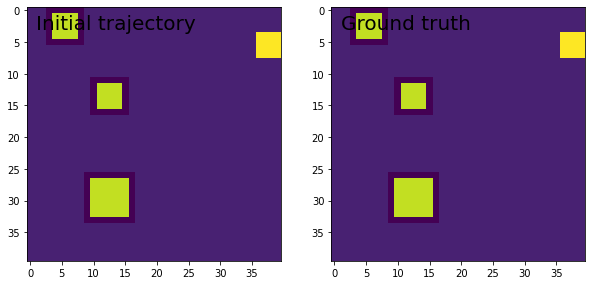

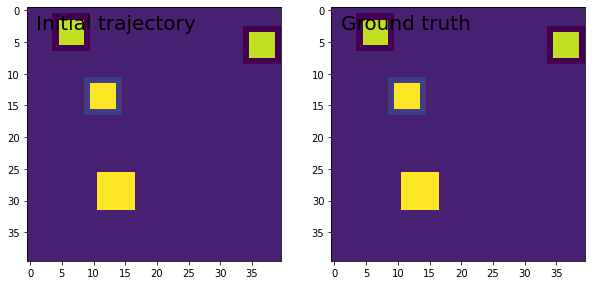

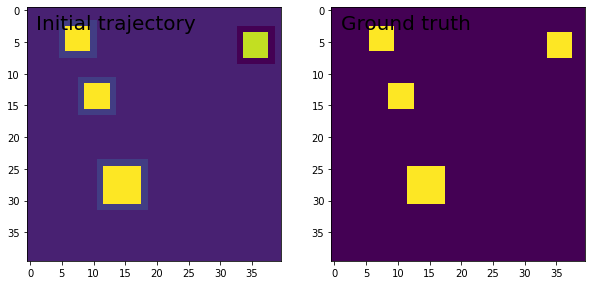

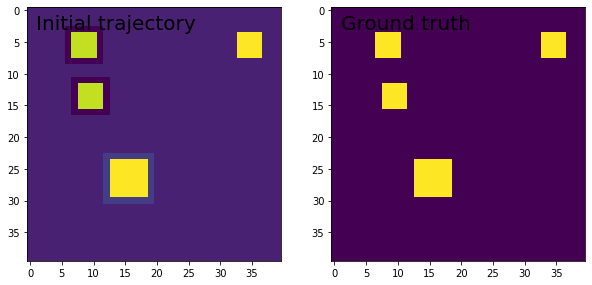

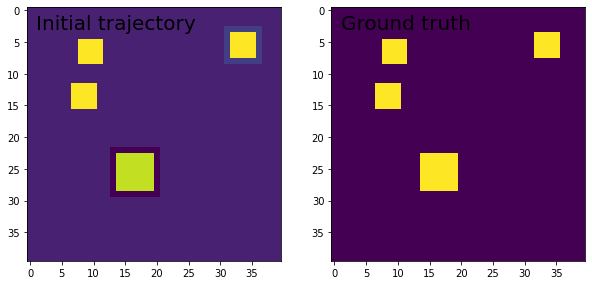

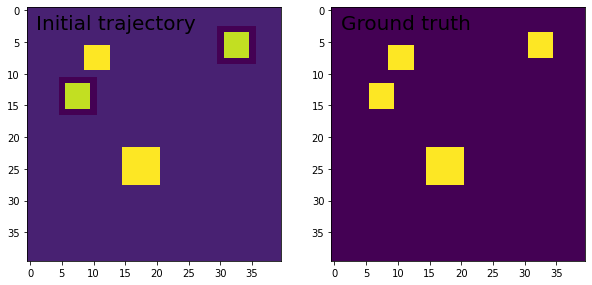

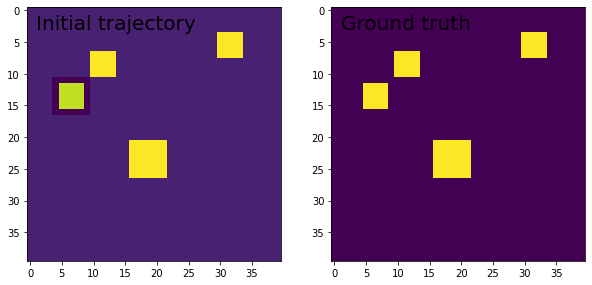

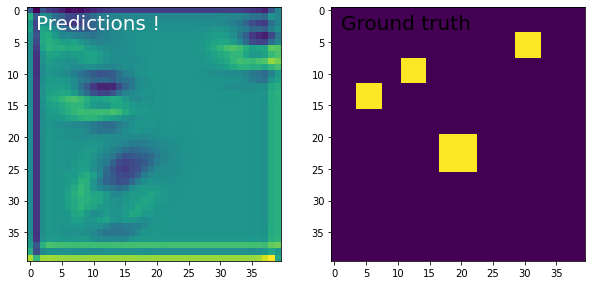

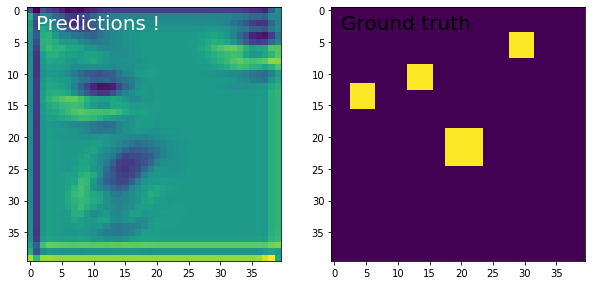

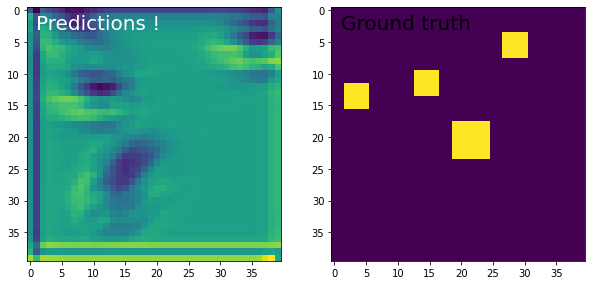

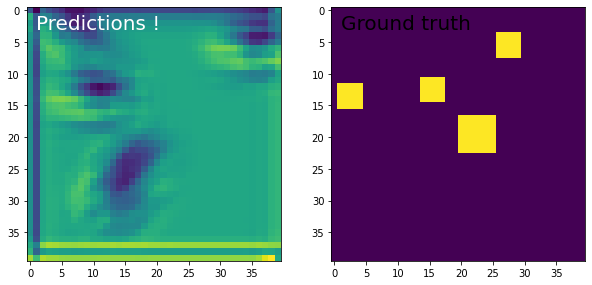

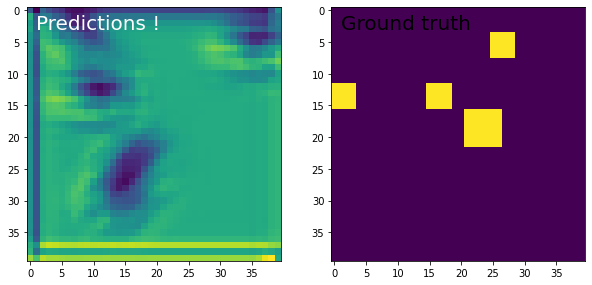

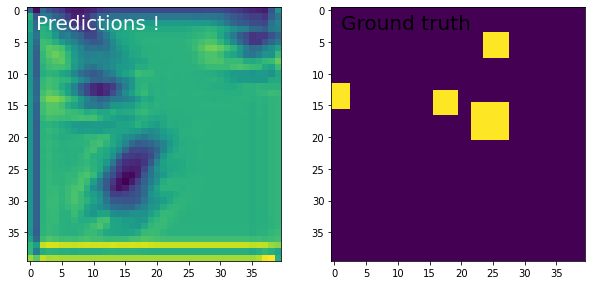

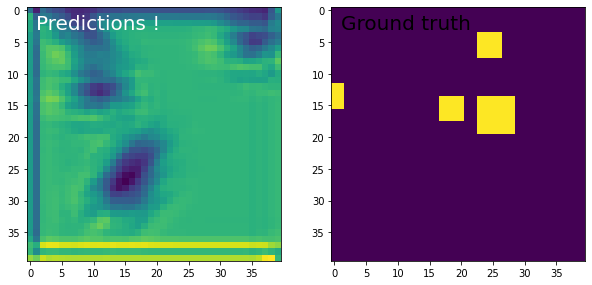

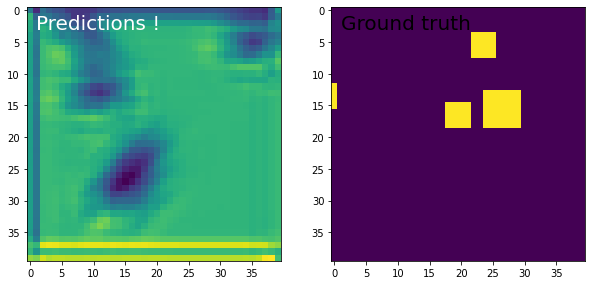

In [5]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import BatchNormalization
import numpy as np
import pylab as plt

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=2, validation_split=0.05)

# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

In [10]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.datasets import imdb

max_features = 20000
maxlen = 80
batch_size = 32
epochs = 5

print('Loading data...')
(X_train, y_train), (X_val, y_val) = imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_val), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_val = sequence.pad_sequences(X_val, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)

def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, y_val))
    score, acc = model.evaluate(X_val, y_val, batch_size=batch_size)
    print('Val score:', score)
    print('Val accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 80)
X_val shape: (25000, 80)


## LSTM

In [11]:
from keras.layers import LSTM

print('Build LSTM model...')
lstm = Sequential()
lstm.add(Embedding(max_features, 128))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

train_and_evaluate(lstm, X_train, y_train, X_val, y_val)

Build LSTM model...
Epoch 1/5
782/782 [==============================] - 207s 262ms/step - loss: 0.4252 - accuracy: 0.8033 - val_loss: 0.3644 - val_accuracy: 0.8408
Epoch 2/5
782/782 [==============================] - 205s 262ms/step - loss: 0.2582 - accuracy: 0.8972 - val_loss: 0.3706 - val_accuracy: 0.8377
Epoch 3/5
782/782 [==============================] - 206s 263ms/step - loss: 0.1676 - accuracy: 0.9385 - val_loss: 0.4601 - val_accuracy: 0.8281
Epoch 4/5
782/782 [==============================] - 206s 263ms/step - loss: 0.1090 - accuracy: 0.9616 - val_loss: 0.5751 - val_accuracy: 0.8145
Epoch 5/5
782/782 [==============================] - 21s 27ms/step - loss: 0.6514 - accuracy: 0.8235
Val score: 0.6514014601707458
Val accuracy: 0.8235200047492981


## SimpleRNN

In [12]:
from keras.layers import SimpleRNN

print('Build SimpleRNN model...')
simpleRNN = Sequential()
simpleRNN.add(Embedding(max_features, 128))
simpleRNN.add(SimpleRNN(128 ,dropout=0.2, recurrent_dropout=0.2))
simpleRNN.add(Dense(1, activation='sigmoid'))
simpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_and_evaluate(simpleRNN, X_train, y_train, X_val, y_val)

Build SimpleRNN model...
Epoch 1/5
782/782 [==============================] - 61s 76ms/step - loss: 0.6851 - accuracy: 0.5475 - val_loss: 0.5481 - val_accuracy: 0.7225
Epoch 2/5
782/782 [==============================] - 60s 77ms/step - loss: 0.5333 - accuracy: 0.7332 - val_loss: 0.4789 - val_accuracy: 0.7809
Epoch 3/5
782/782 [==============================] - 60s 77ms/step - loss: 0.4511 - accuracy: 0.7926 - val_loss: 0.5344 - val_accuracy: 0.7788
Epoch 4/5
782/782 [==============================] - 60s 77ms/step - loss: 0.3753 - accuracy: 0.8421 - val_loss: 0.4814 - val_accuracy: 0.8002
Epoch 5/5
782/782 [==============================] - 7s 9ms/step - loss: 0.4813 - accuracy: 0.7976
Val score: 0.48132553696632385
Val accuracy: 0.7976400256156921


## Gated Recurrent Unit (GRU)

In [13]:
from keras.layers import GRU

print('Build GRU model...')
gru = Sequential()
gru.add(Embedding(max_features, 128))
gru.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
gru.add(Dense(1, activation='sigmoid'))
gru.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

train_and_evaluate(gru, X_train, y_train, X_val, y_val)

Build GRU model...
Epoch 1/5
782/782 [==============================] - 187s 236ms/step - loss: 0.4326 - accuracy: 0.7947 - val_loss: 0.3519 - val_accuracy: 0.8460
Epoch 2/5
782/782 [==============================] - 185s 236ms/step - loss: 0.2467 - accuracy: 0.9040 - val_loss: 0.3656 - val_accuracy: 0.8456
Epoch 3/5
782/782 [==============================] - 183s 235ms/step - loss: 0.1415 - accuracy: 0.9476 - val_loss: 0.4204 - val_accuracy: 0.8345
Epoch 4/5
782/782 [==============================] - 183s 234ms/step - loss: 0.0783 - accuracy: 0.9722 - val_loss: 0.5868 - val_accuracy: 0.8242
Epoch 5/5
782/782 [==============================] - 17s 22ms/step - loss: 0.7249 - accuracy: 0.8186
Val score: 0.7248568534851074
Val accuracy: 0.8185999989509583


# [Problem 2] (Advance assignment) Comparison between multiple data sets

In [21]:
from keras.datasets import reuters
from tensorflow.keras.utils import to_categorical

max_features = 20000
maxlen = 100
batch_size = 32

(X_train, y_train), (X_val, y_val) = reuters.load_data(path='reuters.npz',
                                                       num_words=max_features,
                                                       skip_top=0,
                                                       maxlen=None,
                                                       test_split=0.2,
                                                       seed=113,
                                                       start_char=1,
                                                       oov_char=2,
                                                       index_from=3)

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_val = sequence.pad_sequences(X_val, maxlen=maxlen)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
num_classes = y_train.shape[1]
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('Num classes:', num_classes)

print('Build LSTM model...')
lstm1 = Sequential()
lstm1.add(Embedding(max_features, 128))
lstm1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm1.add(Dense(num_classes, activation='softmax'))
lstm1.summary()
lstm1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_and_evaluate(lstm1, X_train, y_train, X_val, y_val)

2121728/2110848 [==============================] - 0s 0us/step
Pad sequences (samples x time)
X_train shape: (8982, 100)
X_val shape: (2246, 100)
Num classes: 46
Build LSTM model...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 46)                5934      
                                                                 
Total params: 2,697,518
Trainable params: 2,697,518
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
281/281 [==============================] - 87s 300ms/step - loss: 0.1042 - accuracy: 0.3213 - val_loss: 0.0722 - val

# [Problem 3] Explanation of other classes

*   **RNN** (recurrent neural network): Base class for recurrent layers, where connections between nodes form a directed graph along a temporal sequence.
*   **SimpleRNNCell**: Cell class of SimpleRNN, that have the network structure appears recursively.
*   **GRUCell**: a recursive unit with a gate that simplifies LSTM. A structure in which an input gate and a forgetting gate are integrated into one gatet as an 'update date', and is a unit of a hidden layer as a cell for the GRU layer. Therefore the GRUCell is basically the Cell class for GRU layer.
*   **LSTMCell**: Cell class for LSTM layer, which is used by the LSTM layer that contains the calculation logic for one step.
*   **StackedRNNCells**: Wrapper to make the behavior of the RNN cell stack looks like a single cell, which is used to implement an efficient stacked RNN.
*   **CuDNNGRU**: high-speed GRU implementation using CuDNN.
*   **CuDNNLSTM**: high-speed LSTM implementation using CuDNN. Both CuDNNGRU and CuDNNLSTM work on GPU with Tensorflow backend.
